# Imports

In [161]:
import numpy as np
import itertools

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Defining Latex Macros. DO NOT DELETE THIS CELL
$\newcommand\p[2]{\frac{\partial #1}{\partial #2}}$

# Introduction

Consider the following $p$-Laplacian equation:

$$\Delta_p \Psi(x,y)=\pi ^2 (y-1) y \left(3 \pi ^2 y^4-6 \pi ^2 y^3+3 \left(\pi ^2-6\right) y^2+18 y-4\right) \sin (\pi  x) \cos ^2(\pi  x)+\left(\pi ^2 (y-1) y-6\right) (1-2 y)^2 \sin ^3(\pi  x)$$

$x \in [0,1],\ y \in [0,1]$ with *Dirichlet* BC: $\Psi(0,y) = 0$, $\Psi(1,y) = 0$, $\Psi(x,0) = 0$ and $\Psi(x,1) = 0$.

For this case, we will take $p=4$.

$$\Delta_p \Psi(x,y) = f(x,y)$$

# Defining functions

In [162]:
def f(x, y):
    return np.pi**2 * (y-1)*y*(3*np.pi**2*y**4 - 6*np.pi**2*y**3 + 3*(np.pi**2-6)*y**2 + 18*y - 4)*np.sin(np.pi*x)*np.cos(np.pi*x)**2   +   (np.pi**2*(y-1)*y - 6)*(1-2*y)**2*np.sin(np.pi*x)**3

The analytic solution is given by: $\Psi_a(x,y) = y (1-y) \sin(\pi  x)$

In [163]:
def psi_a(x, y):
    return y * (1-y) * np.sin(np.pi * x)

In [164]:
# -π (y - 1) y cos(π x)
def psi_a_dx(x, y):
    return -np.pi*(y-1)*y*np.cos(np.pi*x)

In [165]:
# (1 - 2 y) sin(π x)
def psi_a_dy(x,y):
    return (1-2*y)*np.sin(np.pi*x)

Sigmoid $\sigma(x) = \frac{1}{1+e^{-x}}$ and its derrivatives.

In [166]:
#sigmoid
def sig(x):
    return 1 / (1 + np.exp(-x))

def sig1(x):
    return sig(x) * (1 - sig(x))

def sig2(x):
    return sig1(x) - 2 * sig(x) * sig1(x)

def sig3(x):
    return sig2(x) - 2 * (sig1(x)**2 + sig(x) * sig2(x))

def sig_pr(x, k):
    if k==0:
        return sig(x)
    if k==1:
        return sig1(x)
    if k==2:
        return sig2(x)
    if k==3:
        return sig3(x)

## Neural network and its derivatives

The output of neural network $N(x,y,\vec{p})$, where $\vec{p} = [w, u, v]$:
$$N = \sum_i^H v_i \sigma(z_i) \text{, where } z_i = w_{i0} x + w_{i1} y + u_i$$

In [167]:
def z(x, y, p):
    z_x = np.multiply(x, p[0][0])
    z_y = np.multiply(y, p[0][1])
    z_ = np.array([z_x, z_y, p[1]]).sum(axis=0)
    return z_

def N(x, y, p):
    return np.sum(np.multiply(sig(z(x,y,p)), p[2]))

$$\p{^k N}{ x_j^k} = \sum_{i=1}^H v_i w_{ij}^k \sigma^{(k)}$$

In [168]:
def dN_dxj_k(x, y, p, j, k):
    wj = p[0][j]
    v = p[2]
    z_ = z(x, y, p)
    
    return np.sum(v * (wj**k) * sig_pr(z_, k))

$$\p{}{ x_1}\p{}{ x_2} N = \sum_{i=1}^H v_i w_{i1} w_{i2} \sigma''$$

In [169]:
def dN_dx1_dx2(x, y, p):
    w1 = p[0][0]
    w2 = p[0][1]
    v = p[2]
    z_ = z(x, y, p)
    
    return np.sum(v * w1 * w2 * sig_pr(z_, 2))

$$\p{N}{w_j} = x_j v \sigma '$$

In [170]:
def dN_dwj(x, y, p, j):
    xj = x if j==0 else y
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * sig1(z_)

$$ \p{}{ w_j} \p{ N}{ x_k} = x_j v w_k \sigma'' + v_i \sigma' \quad\text{ if } j = k$$

$$ \p{}{ w_j} \p{ N}{ x_k} = x_j v w_k \sigma'' \quad\text{ if } j \neq k$$

In [171]:
def d_dwj_dN_dxk(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * wk * sig2(z_) + jk * v * sig1(z_)

$$ \p{}{ w_j} \p{^2 N}{ x_k^2} = x_j v w_k^2 \sigma^{(3)} + 2 v w_k \sigma'' \quad\text{ if } j = k $$

$$ \p{}{ w_j} \p{^2 N}{ x_k^2} = x_j v w_k^2 \sigma^{(3)} \quad\text{ if } j \neq k $$

In [172]:
def d_dwj_dN2_dxk2(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * (wk**2) * sig3(z_) + jk * 2 * v * wk * sig2(z_)

$$ \p{}{ w_j}\p{}{ x_1}\p{}{ x_2} N = x_j v w_1 w_2 \sigma^{(3)} + v w_{not j} \sigma'' $$

In [173]:
def d_dwj_d_dx1_dN_dx2(x, y, p, j):
    w1 = p[0][0]
    w2 = p[0][1]
    w_not_j = p[0][1-j]
    xj = x if j==0 else y
    v = p[2]
    z_ = z(x, y, p)
    
    return xj*v*w1*w2*sig_pr(z_,3) + v*w_not_j*sig_pr(z_, 2)

$$ \p{}{u}\p{}{x_1}\p{}{x_2} N = v w_1 w_2 \sigma^{(3)}$$

In [174]:
def d_du_d_dx1_dN_dx2(x, y, p):
    w1 = p[0][0]
    w2 = p[0][1]
    v = p[2]
    z_ = z(x, y, p)
    
    return v*w1*w2*sig_pr(z_, 3)

$$ \p{}{v}\p{}{x_1}\p{}{x_2} N = w_1 w_2 \sigma''$$

In [175]:
def d_dv_d_dx1_dN_dx2(x, y, p):
    w1 = p[0][0]
    w2 = p[0][1]
    z_ = z(x, y, p)
    
    return w1*w2*sig_pr(z_, 2)

$$ \p{}{ u} \p{^k}{ x_j^k} N = v w_j^k \sigma^{(k+1)} $$

In [176]:
def d_du_dkN(x, y, p, j, k):
    v = p[2]
    wj = p[0][j]
    z_ = z(x, y, p)
    return v * (wj**k) * sig_pr(z_, k+1)

$$ \p{}{ v} \p{^k}{ x_j^k} N = w_j^k \sigma^{(k)} $$

In [177]:
def d_dv_dkN(x, y, p, j, k):
    wj = p[0][j]
    z_ = z(x, y, p)
    return (wj**k) * sig_pr(z_, k)

## Trial solution and its derivatives

The trial solution is given by: $$\Psi_t(x,y) = x(1-x)y(1-y)N(x,y,\vec{p})$$

In [178]:
def psi_t(x, y, p):
    return x * (1-x) * y * (1-y) * N(x, y, p)

$$\p{\Psi_t}{x_j} = y_j(1-y_j)\left[ (1-2x_j)N + x_j(1-x_j) \p{N}{x_j} \right]$$

In [179]:
def dPsi_dxj(x, y, p, j):
    xj = x if j==0 else y
    yj = y if j==0 else x
    return yj*(1-yj)*( (1-2*xj)*N(x,y,p) + xj*(1-xj)*dN_dxj_k(x,y,p,j,1) )

$$\p{^2 \Psi_t}{ x_j^2} = y_j(1-y_j)\left[ -2N + (2-4x_j) \p{ N}{ x_j} + x_j (1-x_j) \p{^2 N}{ x_j^2} \right]$$

In [180]:
def dPsi2_dxj2(x, y, p, j):
    xj = x if j==0 else y
    yj = y if j==0 else x
    return yj*(1-yj)*(-2*N(x,y,p) + (2-4*xj)*dN_dxj_k(x,y,p,j,1) + xj*(1-xj)*dN_dxj_k(x,y,p,j,2))

$$\p{}{ y_j}\p{ \Psi_t}{ x_j} = (1-2y_j)\left[ (1-2x_j)N + x_j(1-x_j) \p{ N}{ x_j}\right] + y_j(1-y_j) \left[ (1-2x_j)\p{ N}{ y_j} + x_j(1-x_j) \p{}{ y_j} \p{ N}{ x_j} \right] $$

In [181]:
def d_dy_dPsi_dx(x, y, p, j):
    xj = x if j==0 else y
    yj = y if j==0 else x
    return (1-2*yj)*( (1-2*xj)*N(x,y,p) + xj*(1-xj)*dN_dxj_k(x,y,p,j,1) )  +  yj*(1-yj)*((1-2*xj)*dN_dxj_k(x,y,p,1-j,1) + xj*(1-xj)*dN_dx1_dx2(x,y,p))

$$ |\nabla \Psi| = \left[ \left(\p{\Psi}{x}\right)^2 + \left(\p{\Psi}{y}\right)^2 \right]^{\frac{1}{2}} $$

$$\p{}{v}|\nabla \Psi|^{P} = (P) |\nabla \Psi|^{P-2} \left[\p{ \Psi}{ x} \left(\p{}{v}\p{ \Psi}{ x}\right) + \p{ \Psi}{ y} \left(\p{}{v}\p{ \Psi}{ y}\right) \right]$$

In [182]:
def norm_psi(x, y, p):
    ans = np.sqrt(dPsi_dxj(x,y,p,0)**2 + dPsi_dxj(x,y,p,1)**2)
#     ans = 1e-8 if ans<1e-8 else ans
    ans = np.inf if ans==0 else ans
    return ans

$$\p{}{x_j}|\nabla \Psi|^{p-2} = (p-2) |\nabla \Psi|^{p-4} \left(\p{\Psi}{x_j} \p{^2 \Psi}{x_j^2} + \p{\Psi}{y_j} \left( \p{}{x_j} \p{\Psi}{y_j} \right) \right)$$

In [183]:
def dNormPsi_dxj(x, y, p, j, pLap):
    return (pLap-2)*(norm_psi(x,y,p)**(pLap-4))*( dPsi_dxj(x,y,p,j)*dPsi2_dxj2(x,y,p,j) + dPsi_dxj(x,y,p,1-j)* d_dy_dPsi_dx(x,y,p,1-j))

$$\p{}{ w_j} \p{ \Psi_t}{ x_k} = y_k(1-y_k)\left[ (1-2x)\p{ N}{ w_j} + x(1-x) \p{}{ w_j} \p{ N}{ x_k} \right]$$

In [184]:
def d_dwj_dPsi_dxk(x, y, p, j, k):
    xj = x if k==0 else y
    yj = y if k==0 else x
    return yj*(1-yj)*( (1-2*xj)*dN_dwj(x,y,p,j) + xj*(1-xj)*d_dwj_dN_dxk(x,y,p,j,k) )

$$\p{}{ u} \p{ \Psi_t}{ x_k} = y_k(1-y_k)\left[ (1-2x)\p{ N}{ u} + x(1-x) \p{}{ u} \p{ N}{ x_k} \right]$$

In [185]:
def d_du_dPsi_dxk(x, y, p, k):
    xj = x if k==0 else y
    yj = y if k==0 else x
    return yj*(1-yj)*( (1-2*xj)*d_du_dkN(x,y,p,k,0) + xj*(1-xj)*d_du_dkN(x,y,p,k,1) )

$$\p{}{v} \p{ \Psi_t}{ x_k} = y_k(1-y_k)\left[ (1-2x)\p{ N}{v} + x(1-x) \p{}{v} \p{ N}{ x_k} \right]$$

In [186]:
def d_dv_dPsi_dxk(x, y, p, k):
    xj = x if k==0 else y
    yj = y if k==0 else x
    return yj*(1-yj)*( (1-2*xj)*d_dv_dkN(x,y,p,k,0) + xj*(1-xj)*d_dv_dkN(x,y,p,k,1) )

$$ \p{}{ w_j} \p{^2 \Psi_t}{ x_k^2} = y_k(1-y_k)\left[ -2 \p{ N}{ w_j} + (2-4x_k) \p{}{ w_j}\p{ N}{ x_k} + x_k (1-x_k) \p{}{ w_j}\p{^2 N}{ x_k^2} \right]$$

In [187]:
def d_dwj_dPsi2_dxk2(x, y, p, j, k):
    xk = x if k==0 else y
    yk = y if k==0 else x
    return yk*(1-yk)*(-2*dN_dwj(x,y,p,j) + (2-4*xk)*d_dwj_dN_dxk(x,y,p,j,k) + xk*(1-xk)*d_dwj_dN2_dxk2(x,y,p,j,k))

$$ \p{}{ u} \p{^2 \Psi_t}{ x_k^2} = y_k(1-y_k)\left[ -2 \p{ N}{ u} + (2-4x_k) \p{}{ u}\p{ N}{ x_k} + x_k (1-x_k) \p{}{ u}\p{^2 N}{ x_k^2} \right]$$

In [188]:
def d_du_dPsi2_dxk2(x, y, p, k):
    xk = x if k==0 else y
    yk = y if k==0 else x
    return yk*(1-yk)*(-2*d_du_dkN(x,y,p,k,0) + (2-4*xk)*d_du_dkN(x,y,p,k,1) + xk*(1-xk)*d_du_dkN(x,y,p,k,2))

$$ \p{}{v} \p{^2 \Psi_t}{ x_k^2} = y_k(1-y_k)\left[ -2 \p{ N}{v} + (2-4x_k) \p{}{v}\p{ N}{ x_k} + x_k (1-x_k) \p{}{v}\p{^2 N}{ x_k^2} \right]$$

In [189]:
def d_dv_dPsi2_dxk2(x, y, p, k):
    xk = x if k==0 else y
    yk = y if k==0 else x
    return yk*(1-yk)*(-2*d_dv_dkN(x,y,p,k,0) + (2-4*xk)*d_dv_dkN(x,y,p,k,1) + xk*(1-xk)*d_dv_dkN(x,y,p,k,2))

$$\p{}{ w_j}|\nabla \Psi|^{P} = (P) |\nabla \Psi|^{P-2} \left[\p{ \Psi}{ x} \left(\p{}{ w_j}\p{ \Psi}{ x}\right) + \p{ \Psi}{ y} \left(\p{}{ w_j}\p{ \Psi}{ y}\right) \right]$$

In [190]:
def dNormPsiP_dwj(x, y, p, j, P):
    return P*norm_psi(x,y,p)**(P-2)*(dPsi_dxj(x,y,p,0)*d_dwj_dPsi_dxk(x,y,p,j,0) + dPsi_dxj(x,y,p,1)*d_dwj_dPsi_dxk(x,y,p,j,1))

$$\p{}{ u}|\nabla \Psi|^{P} = (P) |\nabla \Psi|^{P-2} \left[\p{ \Psi}{ x} \left(\p{}{ u}\p{ \Psi}{ x}\right) + \p{ \Psi}{ y} \left(\p{}{ u}\p{ \Psi}{ y}\right) \right]$$

In [191]:
def dNormPsiP_du(x, y, p, P):
    return P*norm_psi(x,y,p)**(P-2)*(dPsi_dxj(x,y,p,0)*d_du_dPsi_dxk(x,y,p,0) + dPsi_dxj(x,y,p,1)*d_du_dPsi_dxk(x,y,p,1))

$$\p{}{v}|\nabla \Psi|^{P} = (P) |\nabla \Psi|^{P-2} \left[\p{ \Psi}{ x} \left(\p{}{v}\p{ \Psi}{ x}\right) + \p{ \Psi}{ y} \left(\p{}{v}\p{ \Psi}{ y}\right) \right]$$

In [192]:
def dNormPsiP_dv(x, y, p, P):
    return P*norm_psi(x,y,p)**(P-2)*(dPsi_dxj(x,y,p,0)*d_dv_dPsi_dxk(x,y,p,0) + dPsi_dxj(x,y,p,1)*d_dv_dPsi_dxk(x,y,p,1))

$$ \p{}{ w_j}\p{}{ y_k}\p{ \Psi_t}{ x_k} = (1-2y_k)\left[ (1-2x_k) \p{ N}{ w_j} + x_k(1-x_k) \p{}{ w_j}\p{ N}{ x_k}\right] + y_k(1-y_k) \left[ (1-2x_k)\p{}{ w_j}\p{ N}{ y_k} + x_k(1-x_k) \p{}{ w_j}\p{}{ y_k} \p{ N}{ x_k} \right] $$

In [193]:
def d_dwj_d_dyk_dPsi_dxk(x, y, p, j, k):
    xk = x if k==0 else y
    yk = y if k==0 else x
    term1 = (1-2*yk)*((1-2*xk)*dN_dwj(x,y,p,j) + xk*(1-xk)*d_dwj_dN_dxk(x,y,p,j,k))
    term2 = yk*(1-yk)*((1-2*xk)*d_dwj_dN_dxk(x,y,p,j,1-k) + xk*(1-xk)*d_dwj_d_dx1_dN_dx2(x,y,p,j))
    
    return term1 + term2

$$ \p{}{ u}\p{}{ y_k}\p{ \Psi_t}{ x_k} = (1-2y_k)\left[ (1-2x_k) \p{ N}{ u} + x_k(1-x_k) \p{}{ u}\p{ N}{ x_k}\right] + y_k(1-y_k) \left[ (1-2x_k)\p{}{ u}\p{ N}{ y_k} + x_k(1-x_k) \p{}{ u}\p{}{ y_k} \p{ N}{ x_k} \right] $$

In [194]:
def d_du_d_dyk_dPsi_dxk(x, y, p, k):
    xk = x if k==0 else y
    yk = y if k==0 else x
    term1 = (1-2*yk)*((1-2*xk)*d_du_dkN(x,y,p,k,0) + xk*(1-xk)*d_du_dkN(x,y,p,k,1))
    term2 = yk*(1-yk)*((1-2*xk)*d_du_dkN(x,y,p,1-k,1) + xk*(1-xk)*d_du_d_dx1_dN_dx2(x,y,p))
    
    return term1 + term2

$$ \p{}{v}\p{}{ y_k}\p{ \Psi_t}{ x_k} = (1-2y_k)\left[ (1-2x_k) \p{ N}{v} + x_k(1-x_k) \p{}{v}\p{ N}{ x_k}\right] + y_k(1-y_k) \left[ (1-2x_k)\p{}{v}\p{ N}{ y_k} + x_k(1-x_k) \p{}{v}\p{}{ y_k} \p{ N}{ x_k} \right] $$

In [195]:
def d_dv_d_dyk_dPsi_dxk(x, y, p, k):
    xk = x if k==0 else y
    yk = y if k==0 else x
    term1 = (1-2*yk)*((1-2*xk)*d_dv_dkN(x,y,p,k,0) + xk*(1-xk)*d_dv_dkN(x,y,p,k,1))
    term2 = yk*(1-yk)*((1-2*xk)*d_dv_dkN(x,y,p,1-k,1) + xk*(1-xk)*d_dv_d_dx1_dN_dx2(x,y,p))
    
    return term1 + term2

$$ \p{}{w_j} \left(\p{\Psi}{x_k} \p{^2 \Psi}{x_k^2} + \p{\Psi}{y_k} \left( \p{}{x_k} \p{\Psi}{y_k} \right) \right) = \left(\p{}{w_j}\p{\Psi}{x_k}\right) \p{^2\Psi}{x_k^2} + \p{\Psi}{x_k} \left(\p{}{w_j}\p{^2\Psi}{x_k^2}\right) + \left(\p{}{w_j}\p{\Psi}{y_k}\right) \left( \p{}{x_k}\p{\Psi}{y_k} \right) + \p{\Psi}{y_k}\left( \p{}{w_j}\p{}{x_k}\p{\Psi}{y_k} \right) $$

In [196]:
def d_dwj_bracket_k(x, y, p, j, k):
    term1 = d_dwj_dPsi_dxk(x,y,p,j,k) * dPsi2_dxj2(x,y,p,k)
    term2 = dPsi_dxj(x,y,p,k) * d_dwj_dPsi2_dxk2(x,y,p,j,k)
    term3 = d_dwj_dPsi_dxk(x,y,p,j,1-k) * d_dy_dPsi_dx(x,y,p,1-k)
    term4 = dPsi_dxj(x,y,p,1-k) * d_dwj_d_dyk_dPsi_dxk(x,y,p,j,1-k)
    
    return term1 + term2 + term3 + term4

$$ \p{}{u} \left(\p{\Psi}{x_k} \p{^2 \Psi}{x_k^2} + \p{\Psi}{y_k} \left( \p{}{x_k} \p{\Psi}{y_k} \right) \right) = \left(\p{}{u}\p{\Psi}{x_k}\right) \p{^2\Psi}{x_k^2} + \p{\Psi}{x_k} \left(\p{}{u}\p{^2\Psi}{x_k^2}\right) + \left(\p{}{u}\p{\Psi}{y_k}\right) \left( \p{}{x_k}\p{\Psi}{y_k} \right) + \p{\Psi}{y_k}\left( \p{}{u}\p{}{x_k}\p{\Psi}{y_k} \right) $$

In [197]:
def d_du_bracket_k(x, y, p, k):
    term1 = d_du_dPsi_dxk(x,y,p,k) * dPsi2_dxj2(x,y,p,k)
    term2 = dPsi_dxj(x,y,p,k) * d_du_dPsi2_dxk2(x,y,p,k)
    term3 = d_du_dPsi_dxk(x,y,p,1-k) * d_dy_dPsi_dx(x,y,p,1-k)
    term4 = dPsi_dxj(x,y,p,1-k) * d_du_d_dyk_dPsi_dxk(x,y,p,1-k)
    
    return term1 + term2 + term3 + term4

$$ \p{}{v} \left(\p{\Psi}{x_k} \p{^2 \Psi}{x_k^2} + \p{\Psi}{y_k} \left( \p{}{x_k} \p{\Psi}{y_k} \right) \right) = \left(\p{}{v}\p{\Psi}{x_k}\right) \p{^2\Psi}{x_k^2} + \p{\Psi}{x_k} \left(\p{}{v}\p{^2\Psi}{x_k^2}\right) + \left(\p{}{v}\p{\Psi}{y_k}\right) \left( \p{}{x_k}\p{\Psi}{y_k} \right) + \p{\Psi}{y_k}\left( \p{}{v}\p{}{x_k}\p{\Psi}{y_k} \right) $$

In [198]:
def d_dv_bracket_k(x, y, p, k):
    term1 = d_dv_dPsi_dxk(x,y,p,k) * dPsi2_dxj2(x,y,p,k)
    term2 = dPsi_dxj(x,y,p,k) * d_dv_dPsi2_dxk2(x,y,p,k)
    term3 = d_dv_dPsi_dxk(x,y,p,1-k) * d_dy_dPsi_dx(x,y,p,1-k)
    term4 = dPsi_dxj(x,y,p,1-k) * d_dv_d_dyk_dPsi_dxk(x,y,p,1-k)
    
    return term1 + term2 + term3 + term4

$$ \p{}{w_j}\p{}{x_k}|\nabla \Psi|^{p-2} = (p-2)\left[ \p{}{w_j}|\nabla \Psi|^{p-4} \left(\p{\Psi}{x_k} \p{^2 \Psi}{x_k^2} + \p{\Psi}{y_k} \left( \p{}{x_k} \p{\Psi}{y_k} \right) \right)  +  |\nabla \Psi|^{p-4} \p{}{w_j} \left(\p{\Psi}{x_k} \p{^2 \Psi}{x_k^2} + \p{\Psi}{y_k} \left( \p{}{x_k} \p{\Psi}{y_k} \right) \right) \right] $$

In [199]:
def d_dwj_dNormPsi_dxk(x, y, p, j, k, pLap):
    term1 = dNormPsiP_dwj(x,y,p,j,pLap-4) * (dPsi_dxj(x,y,p,k)*dPsi2_dxj2(x,y,p,k) + dPsi_dxj(x,y,p,1-k)*d_dy_dPsi_dx(x,y,p,1-k))
    term2 = norm_psi(x,y,p)**(pLap-4) * d_dwj_bracket_k(x,y,p,j,k)
    
    return (pLap-2)*(term1 + term2)

$$ \p{}{u}\p{}{x_k}|\nabla \Psi|^{p-2} = (p-2)\left[ \p{}{u}|\nabla \Psi|^{p-4} \left(\p{\Psi}{x_k} \p{^2 \Psi}{x_k^2} + \p{\Psi}{y_k} \left( \p{}{x_k} \p{\Psi}{y_k} \right) \right)  +  |\nabla \Psi|^{p-4} \p{}{u} \left(\p{\Psi}{x_k} \p{^2 \Psi}{x_k^2} + \p{\Psi}{y_k} \left( \p{}{x_k} \p{\Psi}{y_k} \right) \right) \right] $$

In [200]:
def d_du_dNormPsi_dxk(x, y, p, k, pLap):
    term1 = dNormPsiP_du(x,y,p,pLap-4) * (dPsi_dxj(x,y,p,k)*dPsi2_dxj2(x,y,p,k) + dPsi_dxj(x,y,p,1-k)*d_dy_dPsi_dx(x,y,p,1-k))
    term2 = norm_psi(x,y,p)**(pLap-4) * d_du_bracket_k(x,y,p,k)
    
    return (pLap-2)*(term1 + term2)

$$ \p{}{v}\p{}{x_k}|\nabla \Psi|^{p-2} = (p-2)\left[ \p{}{v}|\nabla \Psi|^{p-4} \left(\p{\Psi}{x_k} \p{^2 \Psi}{x_k^2} + \p{\Psi}{y_k} \left( \p{}{x_k} \p{\Psi}{y_k} \right) \right)  +  |\nabla \Psi|^{p-4} \p{}{v} \left(\p{\Psi}{x_k} \p{^2 \Psi}{x_k^2} + \p{\Psi}{y_k} \left( \p{}{x_k} \p{\Psi}{y_k} \right) \right) \right] $$

In [201]:
def d_dv_dNormPsi_dxk(x, y, p, k, pLap):
    term1 = dNormPsiP_dv(x,y,p,pLap-4) * (dPsi_dxj(x,y,p,k)*dPsi2_dxj2(x,y,p,k) + dPsi_dxj(x,y,p,1-k)*d_dy_dPsi_dx(x,y,p,1-k))
    term2 = norm_psi(x,y,p)**(pLap-4) * d_dv_bracket_k(x,y,p,k)
    
    return (pLap-2)*(term1 + term2)

$$ \p{}{w_j} \left( \p{}{x_k}|\nabla \Psi|^{p-2} \p{\Psi}{x_k} \right) = \left(\p{}{w_j}\p{}{x_k}|\nabla \Psi|^{p-2}\right) \p{\Psi}{x_k} + \p{}{x_k}|\nabla \Psi|^{p-2} \left( \p{}{w_j}\p{\Psi}{x_k} \right) $$

In [202]:
def d_dwj_dNormPsi_dxk_dPsi_dxk(x, y, p, j, k, pLap):
    term1 = d_dwj_dNormPsi_dxk(x, y, p, j, k, pLap) * dPsi_dxj(x, y, p, k)
    term2 = dNormPsi_dxj(x, y, p, k, pLap) * d_dwj_dPsi_dxk(x, y, p, j, k)
    
    return term1 + term2

$$ \p{}{u} \left( \p{}{x_k}|\nabla \Psi|^{p-2} \p{\Psi}{x_k} \right) = \left(\p{}{u}\p{}{x_k}|\nabla \Psi|^{p-2}\right) \p{\Psi}{x_k} + \p{}{x_k}|\nabla \Psi|^{p-2} \left( \p{}{u}\p{\Psi}{x_k} \right) $$

In [203]:
def d_du_dNormPsi_dxk_dPsi_dxk(x, y, p, k, pLap):
    term1 = d_du_dNormPsi_dxk(x, y, p, k, pLap) * dPsi_dxj(x, y, p, k)
    term2 = dNormPsi_dxj(x, y, p, k, pLap) * d_du_dPsi_dxk(x, y, p, k)
    
    return term1 + term2

$$ \p{}{v} \left( \p{}{x_k}|\nabla \Psi|^{p-2} \p{\Psi}{x_k} \right) = \left(\p{}{v}\p{}{x_k}|\nabla \Psi|^{p-2}\right) \p{\Psi}{x_k} + \p{}{x_k}|\nabla \Psi|^{p-2} \left( \p{}{v}\p{\Psi}{x_k} \right) $$

In [204]:
def d_dv_dNormPsi_dxk_dPsi_dxk(x, y, p, k, pLap):
    term1 = d_dv_dNormPsi_dxk(x, y, p, k, pLap) * dPsi_dxj(x, y, p, k)
    term2 = dNormPsi_dxj(x, y, p, k, pLap) * d_dv_dPsi_dxk(x, y, p, k)
    
    return term1 + term2

$$ \p{}{w_j} \left( |\nabla \Psi|^{p-2} \p{^2 \Psi}{x_k^2} \right) = \p{}{w_j}|\nabla \Psi|^{p-2} \p{^2 \Psi}{x_k^2} + |\nabla \Psi|^{p-2} \left( \p{}{w_j} \p{^2 \Psi}{x_k^2} \right) $$

In [205]:
def d_dwj_NormPsi_dPsi2_dxk2(x, y, p, j, k, pLap):
    term1 = dNormPsiP_dwj(x,y,p,j,pLap-2) * dPsi2_dxj2(x,y,p,k)
    term2 = norm_psi(x,y,p)**(pLap-2) * d_dwj_dPsi2_dxk2(x,y,p,j,k)
    return term1 + term2

$$ \p{}{u} \left( |\nabla \Psi|^{p-2} \p{^2 \Psi}{x_k^2} \right) = \p{}{u}|\nabla \Psi|^{p-2} \p{^2 \Psi}{x_k^2} + |\nabla \Psi|^{p-2} \left( \p{}{u} \p{^2 \Psi}{x_k^2} \right) $$

In [206]:
def d_du_NormPsi_dPsi2_dxk2(x, y, p, k, pLap):
    term1 = dNormPsiP_du(x,y,p,pLap-2) * dPsi2_dxj2(x,y,p,k)
    term2 = norm_psi(x,y,p)**(pLap-2) * d_du_dPsi2_dxk2(x,y,p,k)
    return term1 + term2

$$ \p{}{v} \left( |\nabla \Psi|^{p-2} \p{^2 \Psi}{x_k^2} \right) = \p{}{v}|\nabla \Psi|^{p-2} \p{^2 \Psi}{x_k^2} + |\nabla \Psi|^{p-2} \left( \p{}{v} \p{^2 \Psi}{x_k^2} \right) $$

In [207]:
def d_dv_NormPsi_dPsi2_dxk2(x, y, p, k, pLap):
    term1 = dNormPsiP_dv(x,y,p,pLap-2) * dPsi2_dxj2(x,y,p,k)
    term2 = norm_psi(x,y,p)**(pLap-2) * d_dv_dPsi2_dxk2(x,y,p,k)
    return term1 + term2

## Cost function

$$E[\vec{p}] = \sum_i \left\{ \p{}{ x}|\nabla \Psi|^{p-2} \p{\Psi}{ x} + |\nabla \Psi|^{p-2} \p{^2 \Psi}{ x^2} + \p{}{ y}|\nabla \Psi|^{p-2} \p{\Psi}{ y} + |\nabla \Psi|^{p-2} \p{^2 \Psi}{ y^2} - f(x_i,y_i) \right\}^2$$

In [208]:
def error(x, y, p, pLap):
    term1 = dNormPsi_dxj(x,y,p,0,pLap) * dPsi_dxj(x,y,p,0)
    term2 = norm_psi(x,y,p)**(pLap-2) * dPsi2_dxj2(x,y,p,0)
    term3 = dNormPsi_dxj(x,y,p,1,pLap) * dPsi_dxj(x,y,p,1)
    term4 = norm_psi(x,y,p)**(pLap-2) * dPsi2_dxj2(x,y,p,1)
    return term1 + term2 + term3 + term4 - f(x,y)

In [209]:
def cost(p):
    pLap=10
    loss = []
    for x, y in points:
        err_sq = error(x, y, p, pLap)**2
        loss.append(err_sq)

    return sum(loss)

## Gradients

$$ \p{ E[\vec{p}]}{ w_j} = 2 \text{ (error) } \left\{ \p{}{w_j} \left( \p{}{x}|\nabla \Psi|^{p-2} \p{\Psi}{x} \right) + \p{}{w_j} \left( |\nabla \Psi|^{p-2} \p{^2 \Psi}{x^2} \right) + \p{}{w_j} \left( \p{}{y}|\nabla \Psi|^{p-2} \p{\Psi}{y} \right) + \p{}{w_j} \left( |\nabla \Psi|^{p-2} \p{^2 \Psi}{y^2} \right)  \right\} $$

In [210]:
def dE_dwj(x, y, p, j, pLap):
    term1 = d_dwj_dNormPsi_dxk_dPsi_dxk(x,y,p,j,0,pLap)
    term2 = d_dwj_NormPsi_dPsi2_dxk2(x,y,p,j,0,pLap)
    term3 = d_dwj_dNormPsi_dxk_dPsi_dxk(x,y,p,j,1,pLap)
    term4 = d_dwj_NormPsi_dPsi2_dxk2(x,y,p,j,1,pLap)
    
    return 2 * error(x,y,p,pLap) * (term1 + term2 + term3 + term4)

$$\p{ E[\vec{p}]}{u}  = 2 \text{ (error) } \left\{ \p{}{u} \left( \p{}{x}|\nabla \Psi|^{p-2} \p{\Psi}{x} \right) + \p{}{u} \left( |\nabla \Psi|^{p-2} \p{^2 \Psi}{x^2} \right) + \p{}{u} \left( \p{}{y}|\nabla \Psi|^{p-2} \p{\Psi}{y} \right) + \p{}{u} \left( |\nabla \Psi|^{p-2} \p{^2 \Psi}{y^2} \right)  \right\}$$

In [211]:
def dE_du(x, y, p, pLap):
    term1 = d_du_dNormPsi_dxk_dPsi_dxk(x,y,p,0,pLap)
    term2 = d_du_NormPsi_dPsi2_dxk2(x,y,p,0,pLap)
    term3 = d_du_dNormPsi_dxk_dPsi_dxk(x,y,p,1,pLap)
    term4 = d_du_NormPsi_dPsi2_dxk2(x,y,p,1,pLap)
    
    return 2 * error(x,y,p,pLap) * (term1 + term2 + term3 + term4)

$$\p{ E[\vec{p}]}{v}  = 2 \text{ (error) } \left\{ \p{}{v} \left( \p{}{x}|\nabla \Psi|^{p-2} \p{\Psi}{x} \right) + \p{}{v} \left( |\nabla \Psi|^{p-2} \p{^2 \Psi}{x^2} \right) + \p{}{v} \left( \p{}{y}|\nabla \Psi|^{p-2} \p{\Psi}{y} \right) + \p{}{v} \left( |\nabla \Psi|^{p-2} \p{^2 \Psi}{y^2} \right)  \right\}$$

In [212]:
def dE_dv(x, y, p, pLap):
    term1 = d_dv_dNormPsi_dxk_dPsi_dxk(x,y,p,0,pLap)
    term2 = d_dv_NormPsi_dPsi2_dxk2(x,y,p,0,pLap)
    term3 = d_dv_dNormPsi_dxk_dPsi_dxk(x,y,p,1,pLap)
    term4 = d_dv_NormPsi_dPsi2_dxk2(x,y,p,1,pLap)
    
    return 2 * error(x,y,p,pLap) * (term1 + term2 + term3 + term4)

# Training

### Initialization

In [213]:
np.random.seed(10)

nx = 10
dx = 1. / nx
pts = (np.linspace(0, 1, nx), np.linspace(0, 1, nx))
points = list(itertools.product(pts[0], pts[1]))

no_of_nodes = 10

p = np.array([np.random.randn(2,no_of_nodes), np.random.randn(no_of_nodes), np.random.randn(no_of_nodes)])

# original_p = np.empty_like(p)
# np.copyto(original_p, p)

pLap = 4

In [56]:
cost(p)

FloatingPointError: invalid value encountered in double_scalars

In [58]:
error(0,0, p,pLap)

FloatingPointError: invalid value encountered in double_scalars

In [62]:
0.**(-2)

ZeroDivisionError: 0.0 cannot be raised to a negative power

### Stochastic Gradient Descent

In [55]:
# %%pixie_debugger

file = open('output/output.txt', 'w')

# lr = 0.000050000
lr = 0.00010000

itr = 10000

err_rate = []

grw0 = grw1 = gru = grv = []

np.seterr(all='raise')

start=len(err_rate)-1
if start<1:
    err_rate.append(cost(p))

for i in range(start, start+itr):
    np.random.shuffle(points)
    for x, y in points: 
        p[0][0] -= lr * dE_dwj(x, y, p, 0, pLap)
        p[0][1] -= lr * dE_dwj(x, y, p, 1, pLap)
        p[1] -= lr * dE_du(x, y, p, pLap)
        p[2] -= lr * dE_dv(x, y, p, pLap)

    err_rate.append(cost(p))

    file.write('Iteration:{} Cost:{} Improvement:{}'.format(i+1,cost(p), err_rate[i]-err_rate[i+1]) + '\n')
    
    if i%50==0:
        file.flush()

file.close()

np.savez("output/nn_params.npz", p)
np.savez("output/err_rate.npz", err_rate)

FloatingPointError: invalid value encountered in double_scalars

### Save the result

In [181]:
np.savez("output/nn_params.npz", p)
np.savez("output/err_rate.npz", err_rate)

In [67]:
p = np.load("output/nn_params.npz")['arr_0']
err_rate = np.load("output/err_rate.npz")['arr_0']

# Graphs

### Error vs Iterations

In [168]:
def plot_cost(err_rate, min_it=0, max_it=None):
#     %matplotlib tk
#     plt.figure()
    plt.gca().ticklabel_format(useOffset=False)
    plt.gca().set_xlabel('Iterations')
    plt.gca().set_ylabel('Cost')
    plt.plot(np.arange(len(err_rate[min_it:max_it])), np.array(err_rate[min_it:max_it]))
#     plt.ticklabel_format(style='plain', axis='y')
#     plt.show()
    plt.pause(0.1)
    plt.draw()

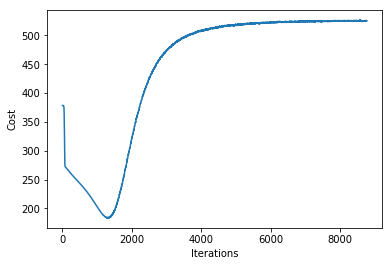

<Figure size 432x288 with 0 Axes>

In [169]:
plot_cost(err_rate)

In [54]:
print('h')

h


In [170]:
a = np.sum(0.01*np.array([np.linalg.norm(psi_t(x,y,p) - psi_a(x,y))**pLap for x, y in points]))**(1/pLap)

In [171]:
b = np.sum([0.01*((dPsi_dxj(x,y,p,0)-psi_a_dx(x,y))**2 + (dPsi_dxj(x,y,p,1)-psi_a_dy(x,y))**2)**(pLap/2) for x, y in points])**(1/pLap)

In [172]:
a+b

0.6105266347865064

In [173]:
norm_psi_a = np.sum(0.01*np.array([np.linalg.norm(psi_a(x,y))**pLap for x, y in points]))**(1/pLap) + np.sum([0.01*(psi_a_dx(x,y)**2 + psi_a_dy(x,y)**2)**(pLap/2) for x, y in points])**(1/pLap)

In [174]:
norm_psi_a

0.7901508312432248

In [175]:
(a+b)/norm_psi_a

0.7726710023526807

### Solution Accuracy on the domain

TypeError: ticklabel_format() got an unexpected keyword argument 'useMathText'

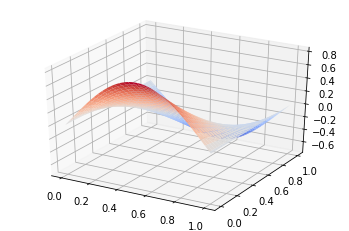

In [176]:
d_x=0.01

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, 1+d_x, d_x)
X, Y = np.meshgrid(x, y)

zs = np.array([psi_a_dy(x,y)-dPsi_dxj(x,y,p,1) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.ticklabel_format(style='sci', axis='z', scilimits=(0,0), useOffset=True, useMathText=True)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Accuracy')

# plt.title(r"$\frac{\partial \Psi_a}{\partial y} - \frac{\partial \Psi_t}{\partial y}$")

plt.show()